In [ ]:
# Cell 1: Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files, drive  # For uploading files
import io  # For reading text

In [ ]:
# Cell 2: Mount Google Drive and upload file
drive.mount('/content/drive')

uploaded = files.upload()  # This opens a file picker; select shakespeare.txt

# Load the text (adjust filename if needed)
filename = list(uploaded.keys())[0]  # Gets the uploaded filename
with io.open(filename, encoding='utf-8') as f:
    text = f.read()

print(f"Text length: {len(text)} characters")
print(f"First 500 chars: {text[:500]}")

Mounted at /content/drive


Saving shakespeare.txt to shakespeare.txt
Text length: 3507498 characters
First 500 chars: 
                    1

From fairest creatures we desire increase,
That thereby beauty’s rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed’st thy light’s flame with self-substantial fuel,
Making a famine where abundance lies,
Thyself thy foe, to thy sweet self too cruel:
Thou that art now the world’s fresh ornament,
And only herald to the gaudy spring,
Within thine own bud buriest thy content,



In [ ]:
# Cell 4: Clean and prepare text
# Step 3.1: Clean text (remove headers, normalize)
# Gutenberg often has Project Gutenberg boilerplate at start/end; manually trim or filter
# For simplicity, filter to alphanumeric + space/punctuation
import re
text = re.sub(r'[^a-zA-Z\s\.\,\!\?\;\:\-\'\"]', '', text)  # Keep letters, space, common punctuation
text = text.lower()  # Lowercase for uniformity
#text = text[1000:-1000]  # Rough trim of headers/footers (adjust based on inspection)

print(f"Cleaned text length: {len(text)}")
print(f"Sample: {text[:200]}")

# Step 3.2: Create vocabulary
chars = sorted(list(set(text)))  # Unique characters
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")
print(f"First 10 chars: {chars[:10]}")

# Step 3.3: Create sequences
seq_length = 100  # Input sequence length (tune: longer = more context, but slower)
step = 3  # Step size for overlapping sequences (smaller = more data)

sentences = []
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])

# Vectorize: inputs as int sequences, targets as one-hot (but we'll use categorical)
X = np.array([[char_to_int[c] for c in sent] for sent in sentences])
y = np.array([char_to_int[c] for c in next_chars])

# Reshape X for LSTM: (samples, seq_length, 1) - embedding will handle the 1D
#X = X.reshape((len(X), seq_length, 1))

print(f"Number of sequences: {len(X)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Sample input: {sentences[0]}")
print(f"Sample target: {next_chars[0]}")

Cleaned text length: 3474566
Sample: 
                    

from fairest creatures we desire increase,
that thereby beautys rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou co
Vocabulary size: 36
First 10 chars: ['\t', '\n', ' ', '!', ',', '-', '.', ':', ';', '?']
Number of sequences: 1158156
X shape: (1158156, 100), y shape: (1158156,)
Sample input: 
                    

from fairest creatures we desire increase,
that thereby beautys rose might ne
Sample target: v


In [ ]:
# Optional: Subsample for faster prototyping (uncomment to use)
subsample = 100000  # Adjust as needed
indices = np.random.choice(len(X), subsample, replace=False)
X = X[indices]
y = y[indices]
sentences = [sentences[i] for i in indices]  # For consistency in prints/generation
next_chars = [next_chars[i] for i in indices]
print(f"Subsampled to {len(X)} sequences")

Subsampled to 100000 sequences


In [ ]:
# Cell 5: Model with higher dropout
model = Sequential([
    Embedding(vocab_size, 128),
    LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.2),  # Increased; recurrent for RNN-specific
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.build(input_shape=(None, seq_length))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,100 (1.56 MB)

 Trainable params: 408,100 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import regularizers

model = Sequential([
    Embedding(vocab_size, 128),
    LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.2,
         kernel_regularizer=regularizers.l2(0.001)),  # L2 on LSTM weights
    Dense(vocab_size, activation='softmax',
          kernel_regularizer=regularizers.l2(0.001))  # L2 on output
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.build(input_shape=(None, seq_length))
model.summary()
# Compile same as before

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 128)       │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,100 (1.56 MB)

 Trainable params: 408,100 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),  # More patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),  # Halve LR if plateau
    ModelCheckpoint('/content/shakespeare_model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=50,  # More epochs with patience
                    validation_data=(X_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
 46/625 ━━━━━━━━━━━━━━━━━━━━ 1:56 201ms/step - accuracy: 0.1449 - loss: 3.4988

KeyboardInterrupt: 

In [ ]:
# Cell 6: Train the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Split data (80/20)
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/shakespeare_model.keras', monitor='val_loss', save_best_only=True)
]

# If subsampled above, this will be faster; else, reduce epochs/batch for full data
history = model.fit(X_train, y_train,
                    batch_size=128,  # Increase to 256 if GPU memory allows
                    epochs=30,  # 20-30 for subsample; 50+ for full
                    validation_data=(X_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 207ms/step - accuracy: 0.2353 - loss: 2.7140 - val_accuracy: 0.3572 - val_loss: 2.1717
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 209ms/step - accuracy: 0.3698 - loss: 2.1281 - val_accuracy: 0.4025 - val_loss: 2.0021
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 209ms/step - accuracy: 0.4108 - loss: 1.9671 - val_accuracy: 0.4261 - val_loss: 1.8981
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 212ms/step - accuracy: 0.4349 - loss: 1.8718 - val_accuracy: 0.4464 - val_loss: 1.8309
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 212ms/step - accuracy: 0.4558 - loss: 1.7960 - val_accuracy: 0.4627 - val_loss: 1.7871
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 213ms/step - accuracy: 0.4741 - loss: 1.7307 - val_accuracy: 0.4721 - val_loss: 1.7470
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 209ms/step - accuracy: 0.4884 - loss: 1.6732 - val_accuracy: 0.4784 - val_loss: 1.7241
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.4968 -

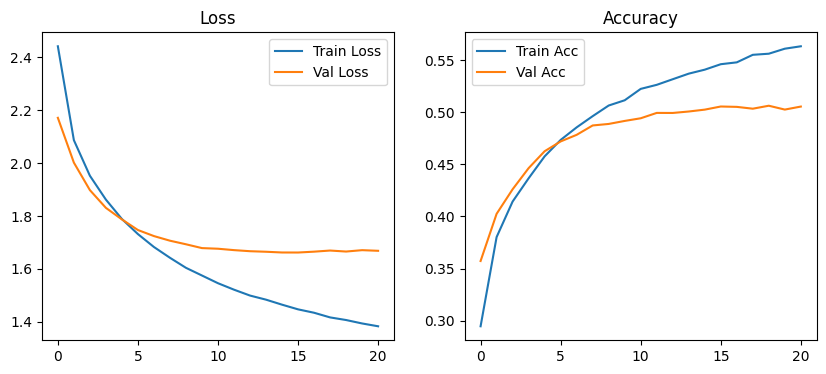

In [ ]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save
model.save('/content/shakespeare_model_not_overfit(max acc 50).keras')
print("Model saved!")

Model saved!


In [ ]:
# Cell 7: Enhanced generation for word prediction
import numpy as np

def predict_next_word(model, char_to_int, int_to_char, seed_text, max_chars=200, temperature=0.7, stop_at_space=True):
    """
    Predicts the next 'word' by generating chars until a space or punctuation, then returns the predicted word.
    - seed_text: Starting phrase (e.g., "to be or not to be")
    - max_chars: Limit generation length to avoid run-on.
    - temperature: 0.5=conservative, 1.0=creative.
    - stop_at_space: If True, stop after next space (for word-by-word).
    """
    generated = seed_text
    start_len = len(generated)

    for _ in range(max_chars):
        # Pad if needed
        if len(generated) < seq_length:
            generated = ' ' * (seq_length - len(generated)) + generated

        x_pred = np.array([char_to_int.get(c, 0) for c in generated[-seq_length:]], dtype='int32').reshape(1, seq_length)
        preds = model.predict(x_pred, verbose=0)[0]
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        next_idx = np.random.choice(vocab_size, p=preds)
        next_char = int_to_char[next_idx]
        generated += next_char

        # Stop if we've predicted a full word (space or end punct)
        if stop_at_space and next_char in [' ', '.', '!', '?', ';', ':', ',']:
            break

    predicted_part = generated[start_len:].strip()  # Extract new part, trim
    return predicted_part.split()[0] if ' ' in predicted_part else predicted_part  # Return first "word"

def generate_full_text(model, char_to_int, int_to_char, seed_text, gen_length=500, temperature=0.7, strip_spaces=True):
    """
    Fixed: Pads input sequence only (not output). Generates clean text.
    """
    generated = seed_text
    space_char = ' '  # Pad with space (common for text start)

    for _ in range(gen_length):
        # Get last seq_length chars for input; pad LEFT if too short
        input_seq = generated[-seq_length:]
        if len(input_seq) < seq_length:
            pad_len = seq_length - len(input_seq)
            input_seq = space_char * pad_len + input_seq  # Left-pad input only

        x_pred = np.array([char_to_int.get(c, 0) for c in input_seq], dtype='int32').reshape(1, seq_length)
        preds = model.predict(x_pred, verbose=0)[0]
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        next_idx = np.random.choice(vocab_size, p=preds)
        generated += int_to_char[next_idx]

    if strip_spaces:
        generated = generated.strip()  # Remove any accidental leading/trailing spaces

    return generated

In [ ]:
# Example 1: Predict next word after a seed
seed1 = "But as the riper should by time decease"
next_word = predict_next_word(model, char_to_int, int_to_char, seed1, max_chars=50, temperature=0.8)
print(f"Seed: '{seed1}'")
print(f"Predicted next word: '{next_word}'")
print(f"Full prediction: '{seed1} {next_word}'")

Seed: 'But as the riper should by time decease'
Predicted next word: 'But'
Full prediction: 'But as the riper should by time decease But'



--- Sequential Word Predictions ---
After '['to', 'be', 'to']': 'to'
After '['be', 'to', 'to']': 'to'
After '['to', 'to', 'to']': 'to'
After '['to', 'to', 'to']': 'to'
After '['to', 'to', 'to']': 'to'


In [ ]:
print("\n--- Fixed Full Generated Snippet ---")
full_gen = generate_full_text(model, char_to_int, int_to_char, "to be or not to be", gen_length=30, temperature=0.7)
print(f"Generated text: {full_gen}")


--- Fixed Full Generated Snippet ---
Generated text: to be or not to be man.

 exeunt.

boyttmer.
the


In [ ]:
# Cell 9: Export model and artifacts
import pickle
from google.colab import files


# Save preprocessing mappings (dicts as pickle)
with open('/content/char_to_int.pkl', 'wb') as f:
    pickle.dump(char_to_int, f)
with open('/content/int_to_char.pkl', 'wb') as f:
    pickle.dump(int_to_char, f)

# Save config (simple text for seq_length, vocab_size)
config = f"seq_length: {seq_length}\nvocab_size: {vocab_size}"
with open('/content/config.txt', 'w') as f:
    f.write(config)